In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os 
os.chdir('content/drive/My Drive/Final_Lab_project/checkpoint_1.pth')

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x58eea000 @  0x7f80aa9112a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import matplotlib.pyplot as plt
import json
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets,transforms,models
from collections import OrderedDict
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
#Download the json file 
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

In [0]:
#Download the Flower Dataset
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip 

In [6]:
!wget -O flower_data_orginal_test.zip "https://www.dropbox.com/s/da6ye9genbsdzbq/flower_data_original_test.zip?dl=1"


--2018-12-25 10:38:46--  https://www.dropbox.com/s/da6ye9genbsdzbq/flower_data_original_test.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/da6ye9genbsdzbq/flower_data_original_test.zip [following]
--2018-12-25 10:38:46--  https://www.dropbox.com/s/dl/da6ye9genbsdzbq/flower_data_original_test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb3dfd1f6d9feb44b8a0825c09c.dl.dropboxusercontent.com/cd/0/get/AYIvRQp2opD5qZM4FitA-P4abrOUWzhwVuo3lm1YS9jAdLdVBX7iwqiX9GQGBH9r3CO60glt9BnisMUeDDAhNMlSIXMFGl57CCv0gqP1LNYWYzIAiNvHhHYT-Sj8vdlWbaS4Cde1_-CxPXcuchbIv_cr45TEQ9DmRxJPzknc4uedbRMEbgsvrImsrLecjPaw4Y4/file?dl=1 [following]
--2018-12-25 10:38:47--  https://ucb3dfd1f6d9feb44b8a0825c09c.dl.dropboxusercontent.com/cd/0

In [0]:
from shutil import unpack_archive
unpack_archive('flower_data_orginal_test.zip', 'test/')

In [0]:
!unzip -qq flower_data.zip

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = 'test'

In [0]:
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],
                                                         [0.229,0.224,0.225])])
test_data = datasets.ImageFolder(test_dir,transform=test_transform)
testloader = torch.utils.data.DataLoader(test_data,batch_size = 64,shuffle = True)

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transform = transforms.Compose([transforms.RandomRotation(10),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],
                                                         [0.229,0.224,0.225])])
valid_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],
                                                         [0.229,0.224,0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir,transform = train_transform)
valid_data = datasets.ImageFolder(valid_dir,transform=valid_transform)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data,batch_size =64,shuffle =True) 
validloader = torch.utils.data.DataLoader(valid_data,batch_size = 64,shuffle = True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    cat_to_name = {int(key):val for key,val in cat_to_name.items()}
len(cat_to_name)

102

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# TODO: Build and train your network
import torchvision.models as models


In [0]:
# # TODO: Build and train your network
# model = models.resnet50(pretrained=True)


In [7]:
# Device agnostic code, automatically uses CUDA if it's enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:

def Network(input_size, output_size, hidden_layers, drop_p):
    model = models.resnet50(pretrained=True)
    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False
    dropa=drop_p[0]
    dropb = drop_p[1]
    # Defining classifier
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_layers[0])),
        ('relu', nn.ReLU()),
        ('drop', nn.Dropout(p=dropa)),
        ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
        ('relu2', nn.ReLU()),
        ('drop2', nn.Dropout(p=dropb)), 
        ('fc3', nn.Linear(hidden_layers[1], output_size)),
        ('output', nn.LogSoftmax(dim=1))
        ]))
    
    model.fc = classifier
    
    return model
  
  
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'],checkpoint['drop_out'])
 
    model.dropout = checkpoint['drop_out']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model
  
model_test = load_checkpoint('/content/drive/My Drive/Final_Lab_project/checkpoint_1.pth')

In [9]:
model_test


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
model_test.to(device);

In [0]:
for param in model_test.parameters():
  param.requires_grad = True

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_test.parameters(), lr=0.0001)

In [16]:
epochs = 15
steps = 0
running_loss = 0
print_every = 40
for epoch in range(epochs):
  
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model_test.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model_test.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model_test.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                  f"Valid accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model_test.train()

Epoch 1/15.. Train loss: 1.010.. Valid loss: 0.499.. Valid accuracy: 0.862
Epoch 1/15.. Train loss: 0.572.. Valid loss: 0.255.. Valid accuracy: 0.936
Epoch 2/15.. Train loss: 0.490.. Valid loss: 0.222.. Valid accuracy: 0.941
Epoch 2/15.. Train loss: 0.411.. Valid loss: 0.190.. Valid accuracy: 0.949
Epoch 2/15.. Train loss: 0.408.. Valid loss: 0.159.. Valid accuracy: 0.961
Epoch 3/15.. Train loss: 0.350.. Valid loss: 0.155.. Valid accuracy: 0.961
Epoch 3/15.. Train loss: 0.291.. Valid loss: 0.134.. Valid accuracy: 0.967
Epoch 4/15.. Train loss: 0.302.. Valid loss: 0.143.. Valid accuracy: 0.963
Epoch 4/15.. Train loss: 0.281.. Valid loss: 0.138.. Valid accuracy: 0.967
Epoch 4/15.. Train loss: 0.289.. Valid loss: 0.158.. Valid accuracy: 0.955
Epoch 5/15.. Train loss: 0.268.. Valid loss: 0.131.. Valid accuracy: 0.968
Epoch 5/15.. Train loss: 0.266.. Valid loss: 0.132.. Valid accuracy: 0.966
Epoch 6/15.. Train loss: 0.257.. Valid loss: 0.154.. Valid accuracy: 0.967
Epoch 6/15.. Train loss: 

KeyboardInterrupt: ignored

In [17]:
 #Testing the model
# TODO: Do accuracy test on the test set
correct = 0
total = 0
model_test.to(device)
model_test.eval()
# criterion = nn.NLLLoss()
with torch.no_grad():
  for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
#     print("Label:",labels)
    logps = model_test.forward(inputs)
#     batch_loss = criterion(logps, labels)
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
#     print("Classes1:",top_class)
    top_class = top_class
    equals = top_class == labels.view(*top_class.shape)
    correct += torch.mean(equals.type(torch.FloatTensor)).item()
print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / len(testloader)))


Accuracy of the network on the test images: 96.39 %


In [18]:
#testing on validation set
 #Testing the model
# TODO: Do accuracy test on the test set
correct = 0
total = 0
model_test.to(device)
model_test.eval()
# criterion = nn.NLLLoss()
with torch.no_grad():
  for inputs, labels in validloader:
    inputs, labels = inputs.to(device), labels.to(device)
#     print("Label:",labels)
    logps = model_test.forward(inputs)
#     batch_loss = criterion(logps, labels)
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
#     print("Classes1:",top_class)
    equals = top_class == labels.view(*top_class.shape)
    correct += torch.mean(equals.type(torch.FloatTensor)).item()
print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / len(validloader)))

Accuracy of the network on the test images: 96.65 %


In [0]:
# TODO: Save the checkpoint 
checkpoint = {'input_size': 2048,
              'output_size': 102,
              'hidden_layers': [500,256],
              'drop_out':[0.3,0.2],
              'state_dict': model_test.state_dict()}

torch.save(checkpoint, '/content/drive/My Drive/Final_Lab_project/checkpoint_accuracy.pth')

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def Network(input_size, output_size, hidden_layers, drop_p):
    model = models.resnet50(pretrained=True)
    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False
        dropa=drop_p[0]
        dropb = drop_p[1]
    # Defining classifier
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_layers[0])),
        ('relu', nn.ReLU()),
        ('drop', nn.Dropout(p=dropa)),
        ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
        ('relu2', nn.ReLU()),
        ('drop2', nn.Dropout(p=dropb)), 
        ('fc3', nn.Linear(hidden_layers[1], output_size)),
        ('output', nn.LogSoftmax(dim=1))
        ]))
    
    model.fc = classifier
    
    return model

In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'],checkpoint['drop_out'])
 
    model.dropout = checkpoint['drop_out']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [25]:
model_load = load_checkpoint('/content/drive/My Drive/Final_Lab_project/checkpoint_accuracy.pth')
model_load

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img_loader = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    
    pil_image = Image.open(image)
    pil_image = img_loader(pil_image).float()
    
    np_image = np.array(pil_image)
    
    
    return np_image

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

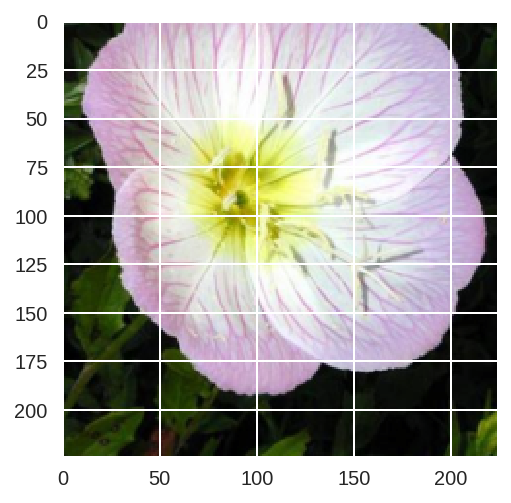

In [28]:
_= imshow(process_image('/content/test/1/image_06743.jpg'))

In [0]:
def predict(image_path, model, topk=5,valid = valid_data):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    image_tensor = torch.from_numpy(image).type(torch.FloatTensor)
    image_tensor.resize_([1, 3, 224, 224])
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    image_tensor = image_tensor.to(device)
    model = model.to(device)
    model.eval()
    
    fc_out = model(image_tensor)

    probs, classes = torch.topk(fc_out, topk)
    # get probabilities from logsoftmax-ed output
    probs = torch.exp(probs)
    # mundane python arrays are expected as an output
    probs, classes = [_ for _ in probs[0].detach().cpu().numpy()], [_ for _ in classes[0].detach().cpu().numpy()]
    idx_to_class = {val: key for key, val in (valid.class_to_idx).items()}
    top_labels = [idx_to_class[lab] for lab in classes]
    top_labels = list(map(int, top_labels))
    return probs, top_labels

In [30]:
prob,classes = predict('/content/test/44/image_01518.jpg', model_test, topk = 5 ,valid = valid_data)
print(prob)
print(classes)


[0.9999961, 4.0545865e-06, 6.1920296e-08, 1.6294162e-08, 7.95169e-09]
[44, 95, 41, 80, 97]


In [0]:
image_path = '/content/test/13/image_05775.jpg'
image_actual_class = 13
image_actual_label = cat_to_name[image_actual_class]

In [32]:
print(image_actual_label)

king protea


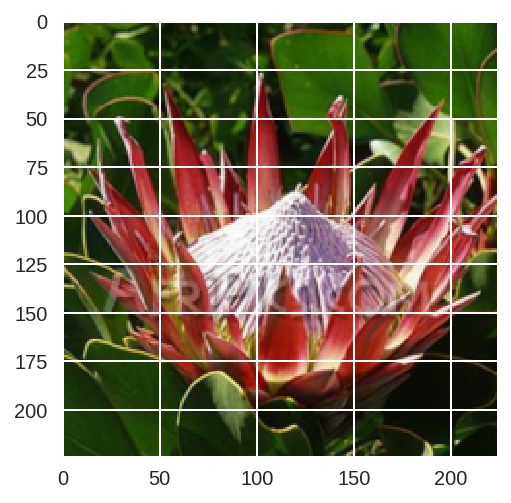

In [33]:
# verify image processing works as expected


img = process_image(image_path)
imshow(img);

In [0]:
def plot_preds(image, title, preds, labels):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
    image: PIL image
    preds: list of predicted labels and their probabilities
    """

    f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})
    ax1.imshow(image)
    ax1.axis('off')
    plt.sca(ax1)
    plt.title(title)

    ax2.barh(range(len(preds)), preds, alpha=0.5)
    plt.sca(ax2)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1.01)
    plt.ylim(len(labels), 0)
    plt.tight_layout()
    plt.show()

[0.99895436, 0.00045782982, 0.0003231572, 6.8742884e-05, 5.48363e-05]
[13, 77, 17, 102, 29]
['king protea', 'passion flower', 'purple coneflower', 'blackberry lily', 'artichoke']


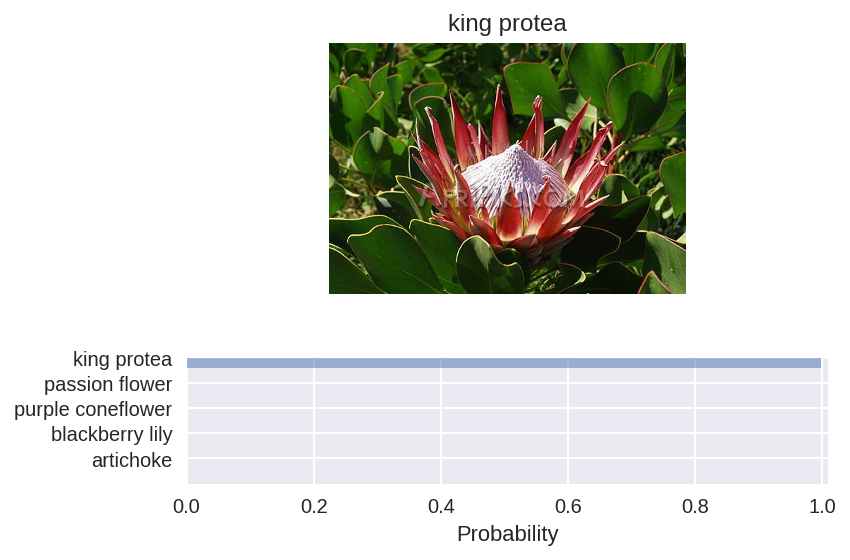

In [35]:
probs, classes = predict(image_path, model_test)

labels = [cat_to_name[cls] for cls in classes]
print(probs)
print(classes)
print(labels)

img = Image.open(image_path)
plot_preds(img, image_actual_label, probs, labels);